<a href="https://colab.research.google.com/github/tronghieu2810/COMPUTER_VISION/blob/main/UDM_Lazy_Programmer_Inc_De_Le_Ad_Co_Vi/TF2_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
# Load in the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Map inputs to (-1, +1) for better training
x_train = x_train / 255.0 * 2 - 1
x_test  = x_test  / 255.0 * 2 - 1

x_train.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
# Flatten the data
N, H, W = x_train.shape
D       = H * W
x_train = x_train.reshape(-1, D)
x_test  = x_test .reshape(-1, D)

x_train.shape

(60000, 784)

In [4]:
# Dimensionality of the latent space
latent_dim = 100

In [5]:
# Get the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    
    x = Dense(units=256,  activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Dense(units=512,  activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Dense(units=1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Dense(D, activation='tanh')(x) # Image between -1 & +1
    
    model = Model(i, x)
    return model

In [6]:
# Get the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(units=512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(units=256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(units=1,   activation='sigmoid')           (x)
    
    model = Model(i, x)
    return model

In [7]:
# Compile both models in preparation for training

# Build & compile the D
discriminator = build_discriminator(img_size=D)
discriminator.compile( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build & compile the combined model
generator = build_generator(latent_dim=latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [8]:
# Train the GAN

# Config
batch_size    = 32
epochs        = 30000
sample_period = 200 # Every `sample_period` steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones  = np.ones (batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [9]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise      = np.random.randn(rows * cols, latent_dim) # Generator random noise vector from the latent space
    imgs       = generator.predict(noise)                 # Get generated samples (-1 -> +1)
    
    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols)
    idx      = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
        fig.savefig(f'gan_images/{epoch}.png')
        plt.close()

In [10]:
# Main training loop
for epoch in range(epochs):
    #######################
    # Train discriminator #
    #######################
    
    # Select a random batch of images
    idx       = np.random.randint(low=0, high=x_train.shape[0], size=batch_size)
    real_imgs = x_train[idx]
    
    # Generate fake images
    noise     = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    # Both loss & accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss                  = (d_loss_real + d_loss_fake) / 2
    d_acc                   = (d_acc_real  + d_acc_fake)  / 2
    
    ###################
    # Train generator #
    ###################
    
    noise  = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if (epoch % 100 == 0):
        print(f'Epoch: {epoch+1:<5}/{epochs}, d_loss: {d_loss:<4.2f}, d_acc: {d_acc:<4.2f}, g_loss: {g_loss:<4.2f}')
    if (epoch % sample_period == 0):
        sample_images(epoch)

Epoch: 1    /30000, d_loss: 0.59, d_acc: 0.53, g_loss: 0.47
Epoch: 101  /30000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.78
Epoch: 201  /30000, d_loss: 0.02, d_acc: 1.00, g_loss: 4.96
Epoch: 301  /30000, d_loss: 0.26, d_acc: 0.91, g_loss: 3.54
Epoch: 401  /30000, d_loss: 0.35, d_acc: 0.80, g_loss: 2.35
Epoch: 501  /30000, d_loss: 0.70, d_acc: 0.47, g_loss: 0.73
Epoch: 601  /30000, d_loss: 0.67, d_acc: 0.53, g_loss: 0.72
Epoch: 701  /30000, d_loss: 0.63, d_acc: 0.64, g_loss: 0.74
Epoch: 801  /30000, d_loss: 0.61, d_acc: 0.64, g_loss: 0.78
Epoch: 901  /30000, d_loss: 0.62, d_acc: 0.58, g_loss: 0.79
Epoch: 1001 /30000, d_loss: 0.62, d_acc: 0.69, g_loss: 0.76
Epoch: 1101 /30000, d_loss: 0.62, d_acc: 0.64, g_loss: 0.78
Epoch: 1201 /30000, d_loss: 0.61, d_acc: 0.77, g_loss: 0.82
Epoch: 1301 /30000, d_loss: 0.58, d_acc: 0.78, g_loss: 0.89
Epoch: 1401 /30000, d_loss: 0.56, d_acc: 0.83, g_loss: 0.96
Epoch: 1501 /30000, d_loss: 0.58, d_acc: 0.67, g_loss: 0.92
Epoch: 1601 /30000, d_loss: 0.55, d_acc:

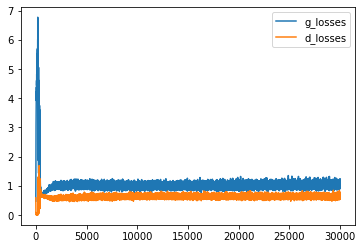

In [11]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

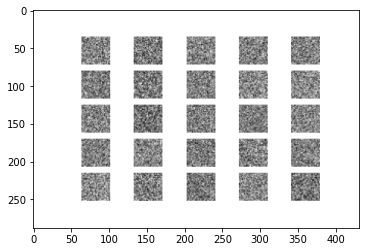

In [12]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

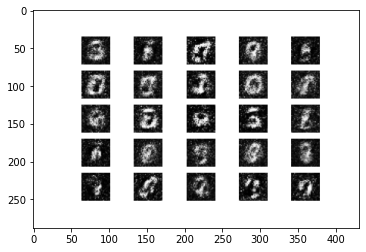

In [13]:
a = imread('gan_images/1000.png')
plt.imshow(a)

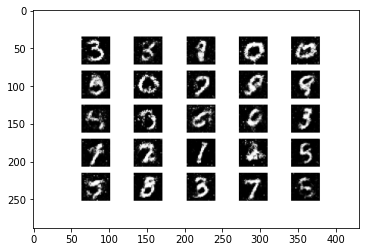

In [14]:
a = imread('gan_images/5000.png')
plt.imshow(a)

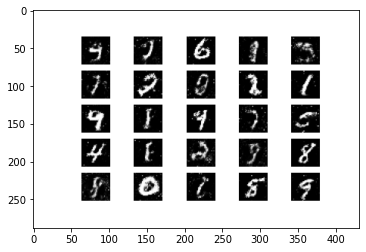

In [15]:
a = imread('gan_images/10000.png')
plt.imshow(a)

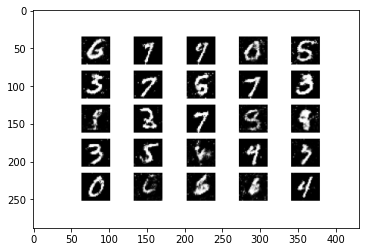

In [16]:
a = imread('gan_images/20000.png')
plt.imshow(a)

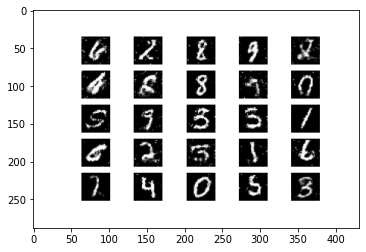

In [17]:
a = imread('gan_images/29800.png')
plt.imshow(a)